# Lab#7
Noam Yan

<br><br>
I choose high-pt data ranging from 1000 to 1200.
## 1.

In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats

In [2]:
higgs_df = pd.read_pickle("higgs.pkl")
qcd_df = pd.read_pickle("qcd.pkl")

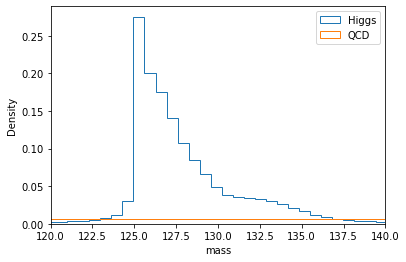

In [3]:
plt.hist(higgs_df['mass'],200,density=True,histtype='step',label="Higgs")
plt.hist(qcd_df['mass'],200,density=True,histtype='step', label='QCD')
plt.legend()
plt.xlabel('mass')
plt.ylabel('Density')
plt.xlim([120,140])
plt.show()

In [4]:
N_higgs = 50
N_QCD  = 2000

significance = stats.norm.isf(stats.poisson.sf(N_higgs+N_QCD, mu = 2000))
print("The significance is %.2f. N_Higgs/(√N_QCD) is %.2f" %(significance, N_higgs/np.sqrt(N_QCD)))

The significance is 1.13. N_Higgs/(√N_QCD) is 1.12


This is how we calculate the standard deviation, so they are expected to be equivalent.<br><br>
## 2. 
From the distribution of mass, we know that QCD is uniformly distributed. To opmitmize the expected significance, we need to find the peak of higgs data.

In [5]:
def get_ranges (higgs_df, qcd_df, features):
    range_collections = {}
    for feature in features:
        hist, bins = np.histogram(higgs_df[feature],bins=100,density=True)
        lowerbound = bins[np.where(hist==hist.max())][0]
        upperbound = bins[np.where(hist==hist.max())[0]+1][0]
        range_collections[feature] = [lowerbound,upperbound]
    return range_collections

def cut_df (range_collections, higgs_df, qcd_df):
    higgs_cond = np.repeat([True],100000)
    qcd_cond = np.repeat([True],100000)
    for feature, r in range_collections.items():
        higgs_cond = higgs_cond & (higgs_df[feature] > r[0]) & (higgs_df[feature] < r[1])
        qcd_cond = qcd_cond & (qcd_df[feature] > r[0]) & (qcd_df[feature] < r[1])
    return higgs_df[higgs_cond], qcd_df[qcd_cond]

def sig_cal(higgs_df, qcd_df):
    N_higgs = higgs_df.shape[0]
    N_qcd = qcd_df.shape[0]
    # Normalization
    N_higgs_n = N_higgs * 50 / 100000
    N_qcd_n = N_qcd * 2000 / 100000                   # When N_qcd < 50, normalization yields a number < 1 
                                                      # => Sqrt make it greater
                                                      # => significance is reduced ! 
                                                      # To solve this problem, I have to enlarge the bin size to avoid the unexpected situation.
    return N_higgs_n / np.sqrt(N_qcd_n)

In [6]:
range_collections = get_ranges(higgs_df,qcd_df, ['mass'])

h_c, q_c = cut_df(range_collections,higgs_df,qcd_df)
sig_exp = sig_cal(h_c,q_c)
print("The optimizing condition is %s" %(range_collections['mass']))
print("The expected siginificance is %.2f." %sig_exp)

The optimizing condition is [125.6091423607632, 126.9275302079706]
The expected siginificance is 3.12.


## 3. 
### SET A

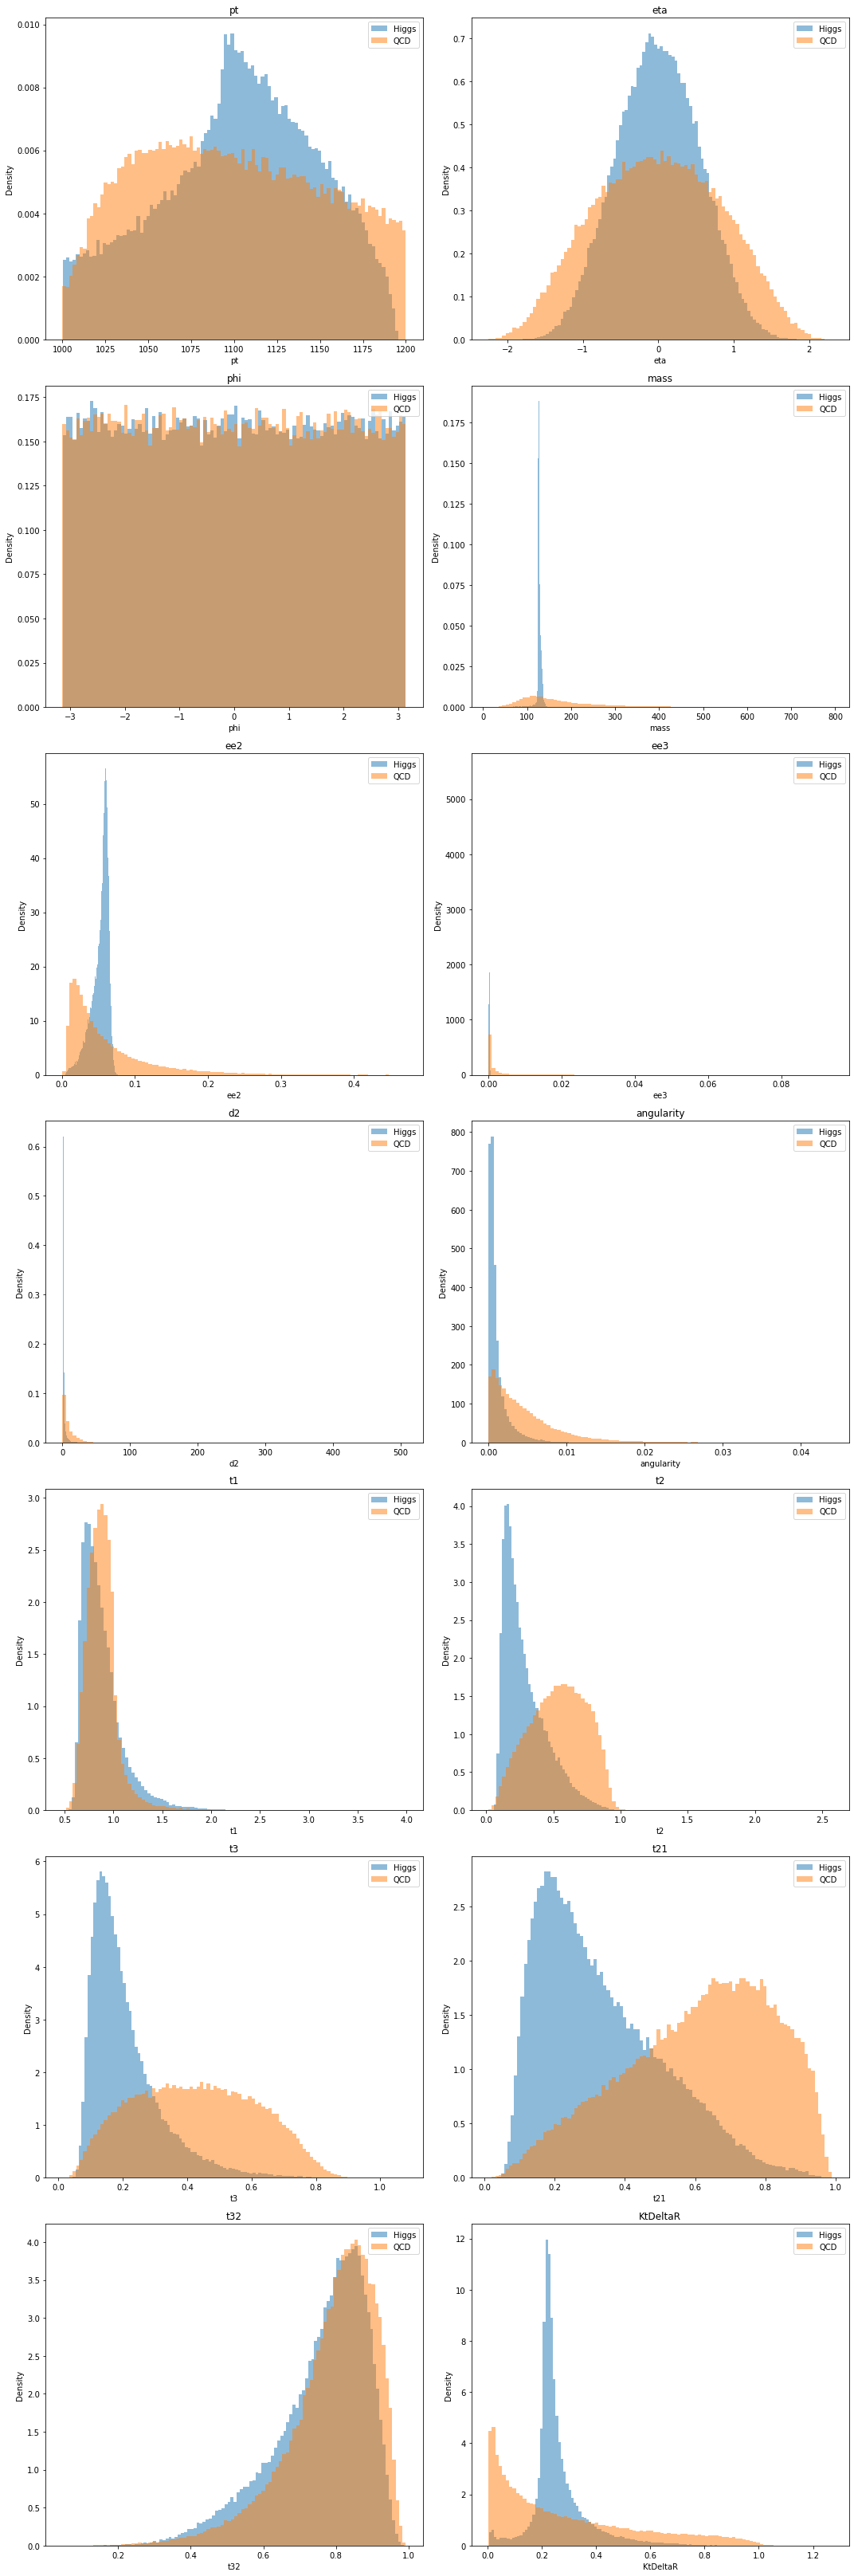

In [7]:
cols = higgs_df.columns.values
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_df[col],100,density=True,alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_df[col],100,density=True,alpha=.5, label='QCD')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

The plots above shows the distribution of each feature. Through comparison between two datasets, we can have a rough understanding about which feature can help us distinguish them. The more disparate are those two distribution, the easier we can discriminate by such feature.<br> <br>
I'd like to choose t21 and t3 as discriminative features.

In [8]:
def sig_disc (feature, higgs_df, qcd_df, returnSig=True):
    hist, bins = np.histogram(higgs_df[feature],'auto',density=True)
    lowerbound = bins[np.where(hist==hist.max())]
    upperbound = bins[np.where(hist==hist.max())[0]+1]
    N_higgs = higgs_df[(higgs_df[feature] > lowerbound[0]) & (higgs_df[feature] < upperbound[0])].shape[0]
    N_qcd = qcd_df[(qcd_df[feature] > lowerbound[0]) & (qcd_df[feature] < upperbound[0])].shape[0]
    # Normalization
    N_higgs_n = N_higgs * 50 / higgs_df.shape[0]
    N_qcd_n = N_qcd * 2000 / qcd_df.shape[0]
    significance = N_higgs_n / np.sqrt(N_qcd_n)
    if returnSig:
        return significance
    return N_higgs, N_qcd
    
sig_t21 = sig_disc("t21",higgs_df,qcd_df)
sig_t3 = sig_disc("t3",higgs_df,qcd_df)
print("The optimized significance of t21 is %.2f." %sig_t21)
print("The optimized significance of t3 is %.2f." %sig_t3)

The optimized significance of t21 is 0.49.
The optimized significance of t3 is 0.47.


### SET B

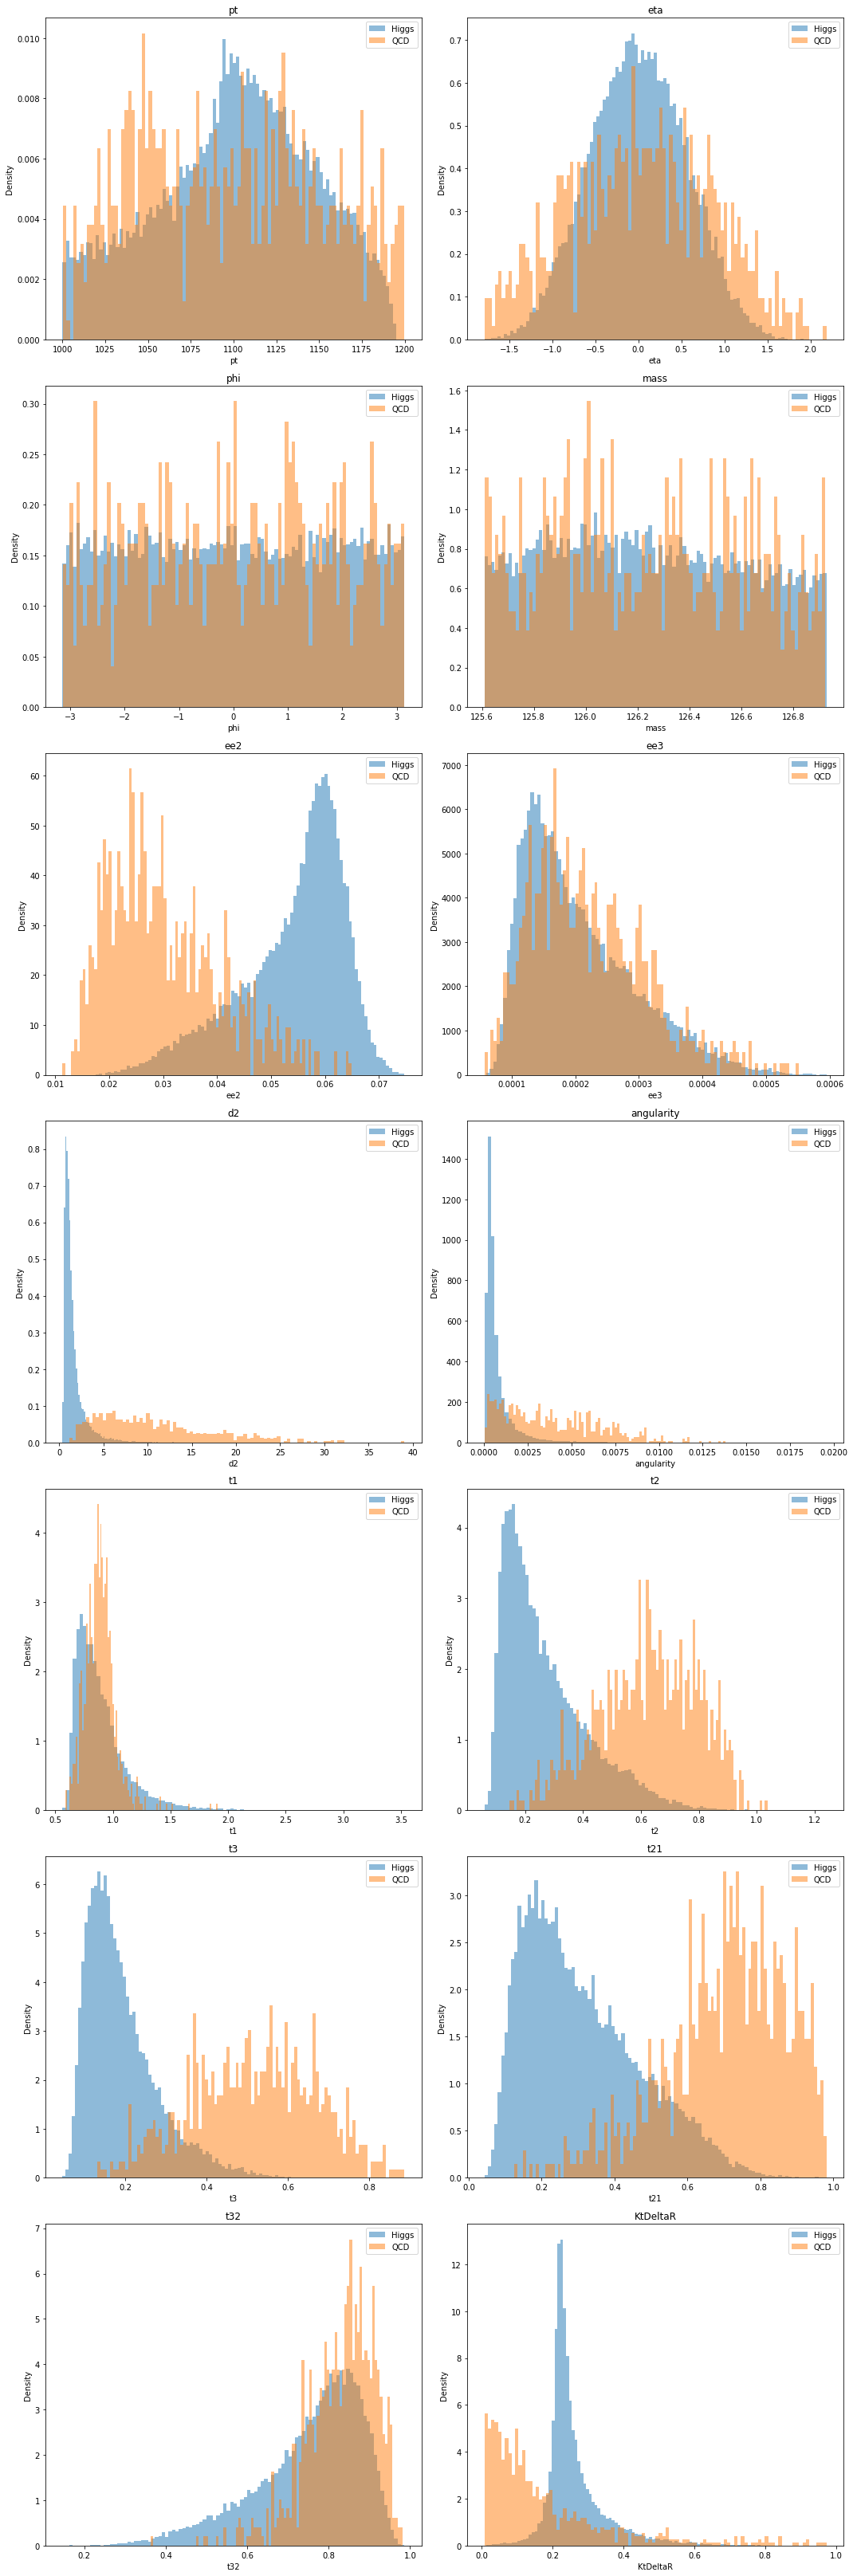

In [9]:
higgs_cutted, qcd_cutted = cut_df(range_collections,higgs_df,qcd_df)

cols = higgs_cutted.columns.values
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_cutted[col],100,density=True,alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_cutted[col],100,density=True,alpha=.5, label='QCD')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

According to the plots, "mass" works pretty well. To improve the performance, I will choose "angularity" for further classification 
## 4.

In [10]:
range_collections = get_ranges(higgs_df,qcd_df, ['mass','angularity'])

h_c, q_c = cut_df(range_collections,higgs_df,qcd_df)
print("The optimizing conditions are %s" %(range_collections))
print("The siginificance is %.2f." %sig_cal(h_c,q_c))

The optimizing conditions are {'mass': [125.6091423607632, 126.9275302079706], 'angularity': [0.0003381766669432101, 0.0006685798017413968]}
The siginificance is 3.82.


# Lab #8

In [11]:
highLum = pd.read_hdf("data_highLumi_pt_1000_1200.h5",key='data')
lowLum = pd.read_hdf("data_lowLumi_pt_1000_1200.h5",key='data')

## High-Luminosity Data
Let's visualize the highg-luminosity data in histogram.

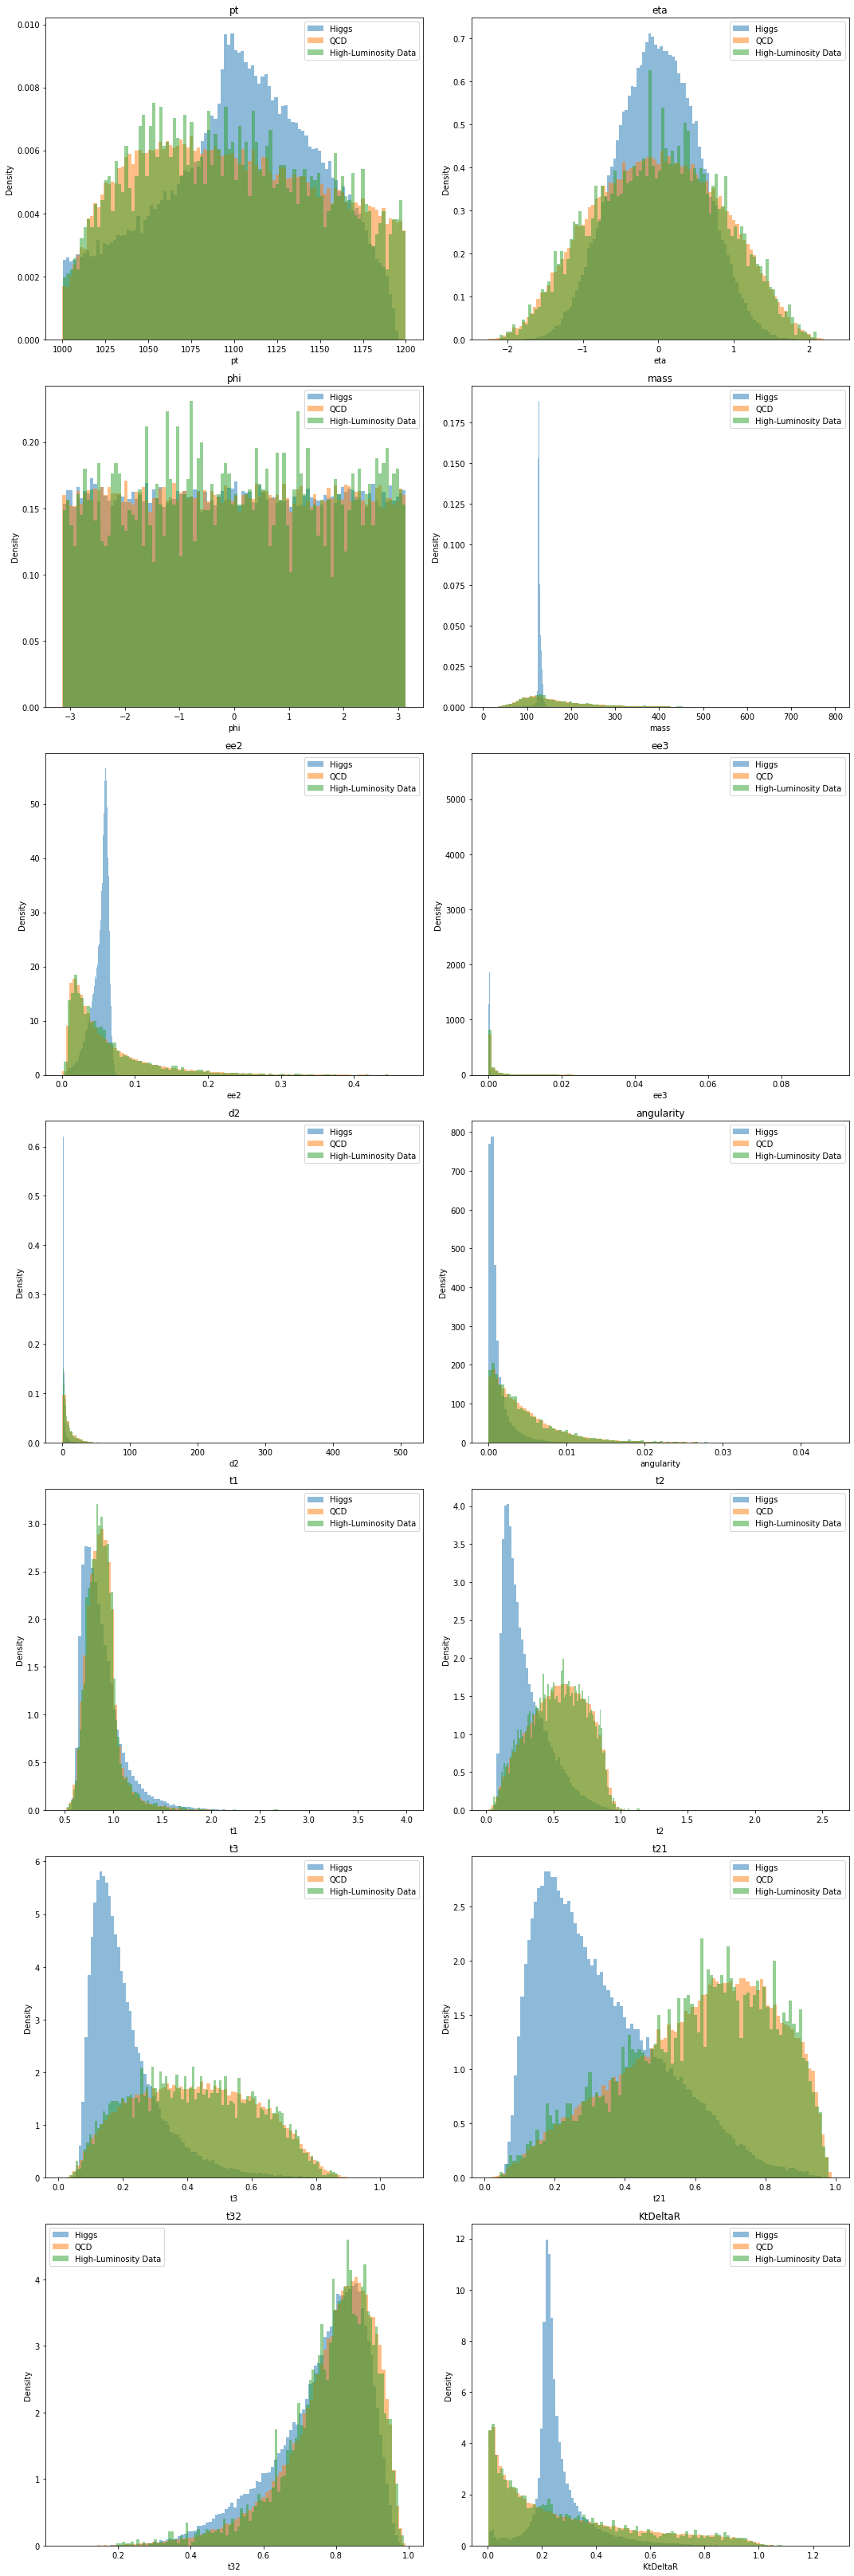

In [12]:
cols = higgs_df.columns.values
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_df[col],100,density=True,weights = np.full(higgs_df.shape[0],highLum.shape[0]/higgs_df.shape[0]), alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_df[col],100,density=True,weights = np.full(qcd_df.shape[0],highLum.shape[0]/qcd_df.shape[0]), alpha=.5, label='QCD')
    ax[i//2,i%2].hist(highLum[col],100,density=True,alpha=.5, label='High-Luminosity Data')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

### Optimizing the data
I am gonna use the same condition in Lab#7: mass \[125.6091423607632, 126.9275302079706].

In [13]:
def cut_df_2 (range_collections, higgs_df, qcd_df, data):
    higgs_cond = np.repeat([True],100000)
    qcd_cond = np.repeat([True],100000)
    data_cond = np.repeat([True],data.shape[0])
    for feature, r in range_collections.items():
        higgs_cond = higgs_cond & (higgs_df[feature] > r[0]) & (higgs_df[feature] < r[1])
        qcd_cond = qcd_cond & (qcd_df[feature] > r[0]) & (qcd_df[feature] < r[1])
        data_cond = data_cond & (data[feature] > r[0]) & (data[feature] < r[1])
    return higgs_df[higgs_cond], qcd_df[qcd_cond], data[data_cond]

In [14]:
range_collections = get_ranges(higgs_df,qcd_df, ['mass'])
higgs_opt, qcd_opt, highLum_opt = cut_df_2(range_collections,higgs_df,qcd_df,highLum)

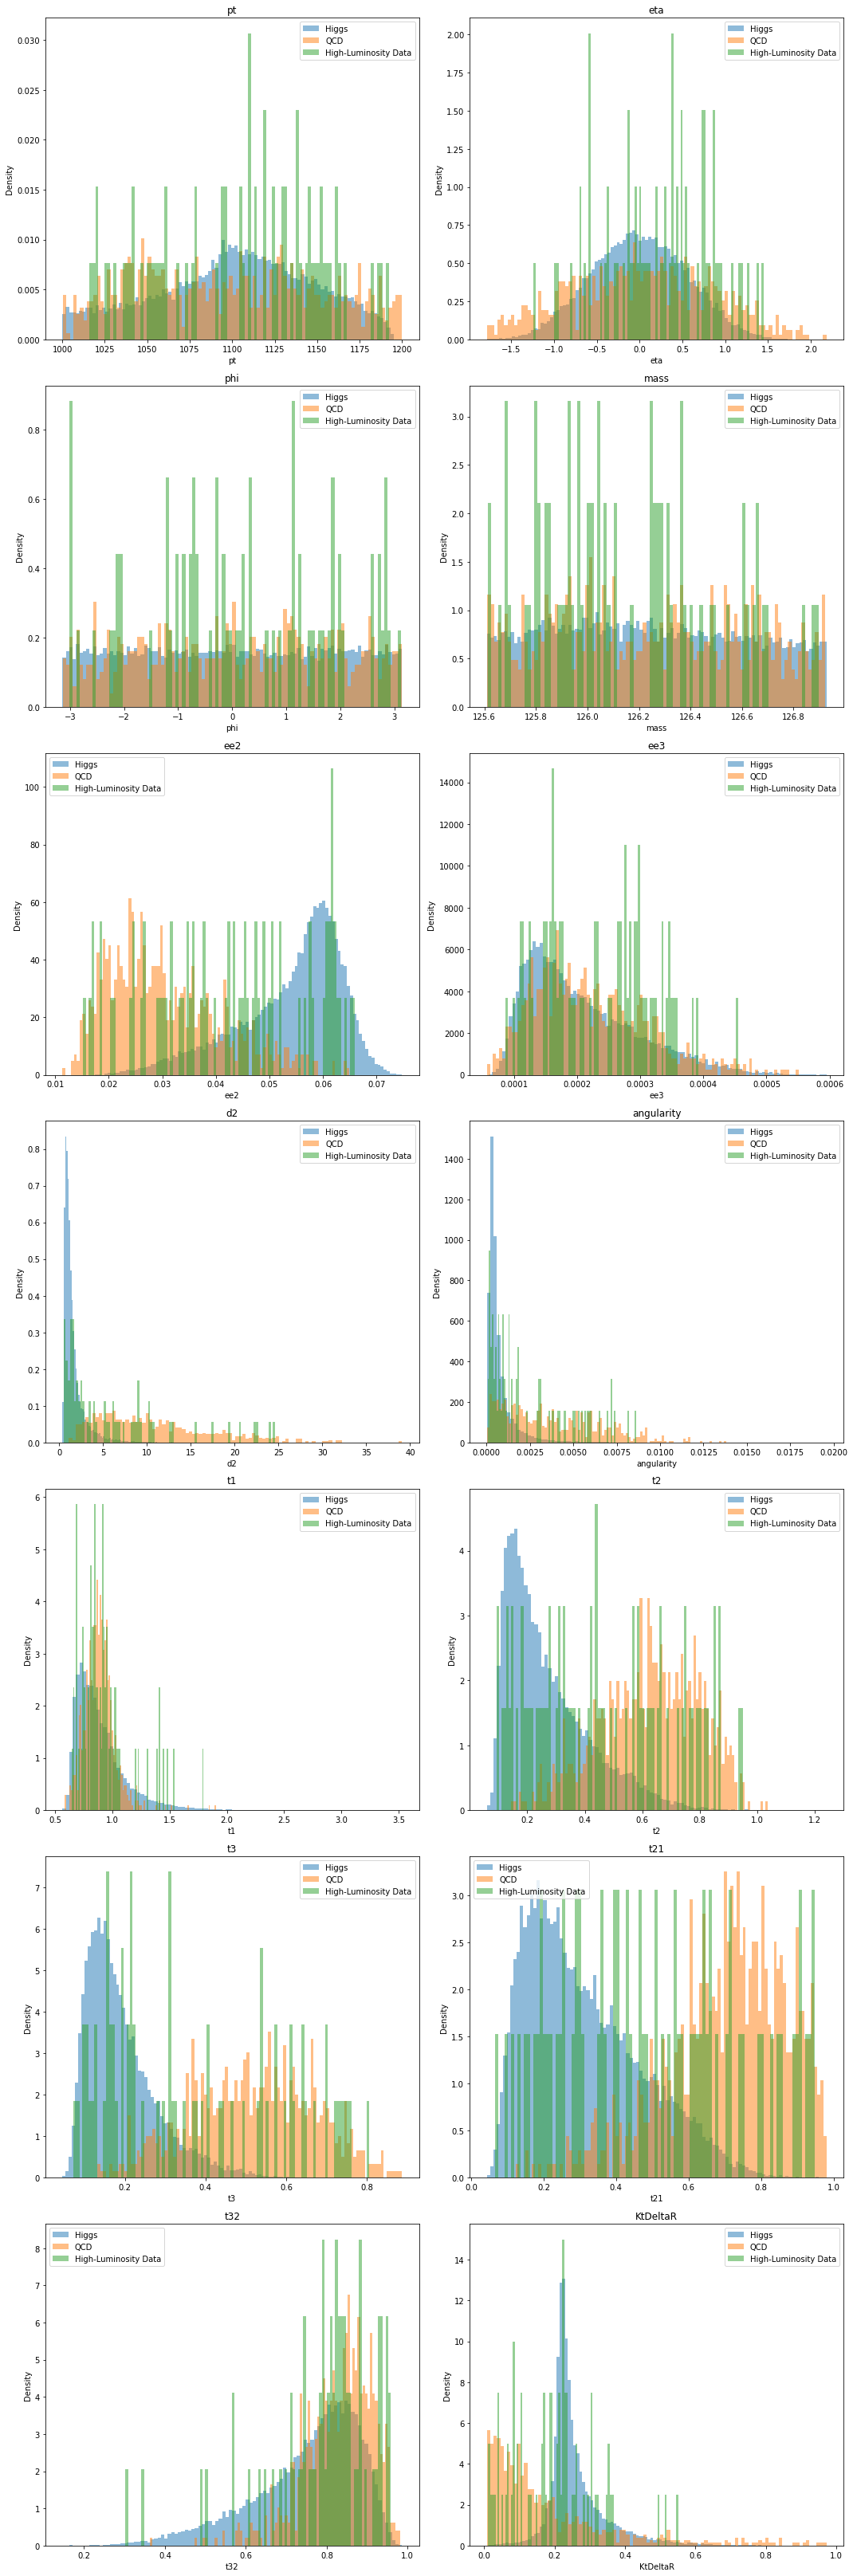

In [15]:
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_opt[col],100,density=True,weights = np.full(higgs_opt.shape[0],highLum_opt.shape[0]/higgs_df.shape[0]),alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_opt[col],100,density=True,weights = np.full(qcd_opt.shape[0],highLum_opt.shape[0]/qcd_df.shape[0]),alpha=.5, label='QCD')
    ax[i//2,i%2].hist(highLum_opt[col],100,density=True,alpha=.5, label='High-Luminosity Data')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

In [16]:
def sig_cal_2(higgs_df, qcd_df,lum_df,lum_opt):
    N_higgs = higgs_df.shape[0]
    N_qcd = qcd_df.shape[0]
    N_lum = lum_opt.shape[0]
    # Normalization
    N_higgs_n = N_higgs * 50 / 100000
    N_bg = N_lum * 2050 / lum_df.shape[0]             
    return N_higgs_n / np.sqrt(N_bg)

In [17]:
sig_highLum = sig_cal_2(higgs_opt,qcd_opt,highLum,highLum_opt)

print("The expected significance is %.2f." %sig_exp)
print("The observed significance of high-luminosity data is %.2f."%sig_highLum)

The expected significance is 3.12.
The observed significance of high-luminosity data is 2.03.


## Low-luminosity Data

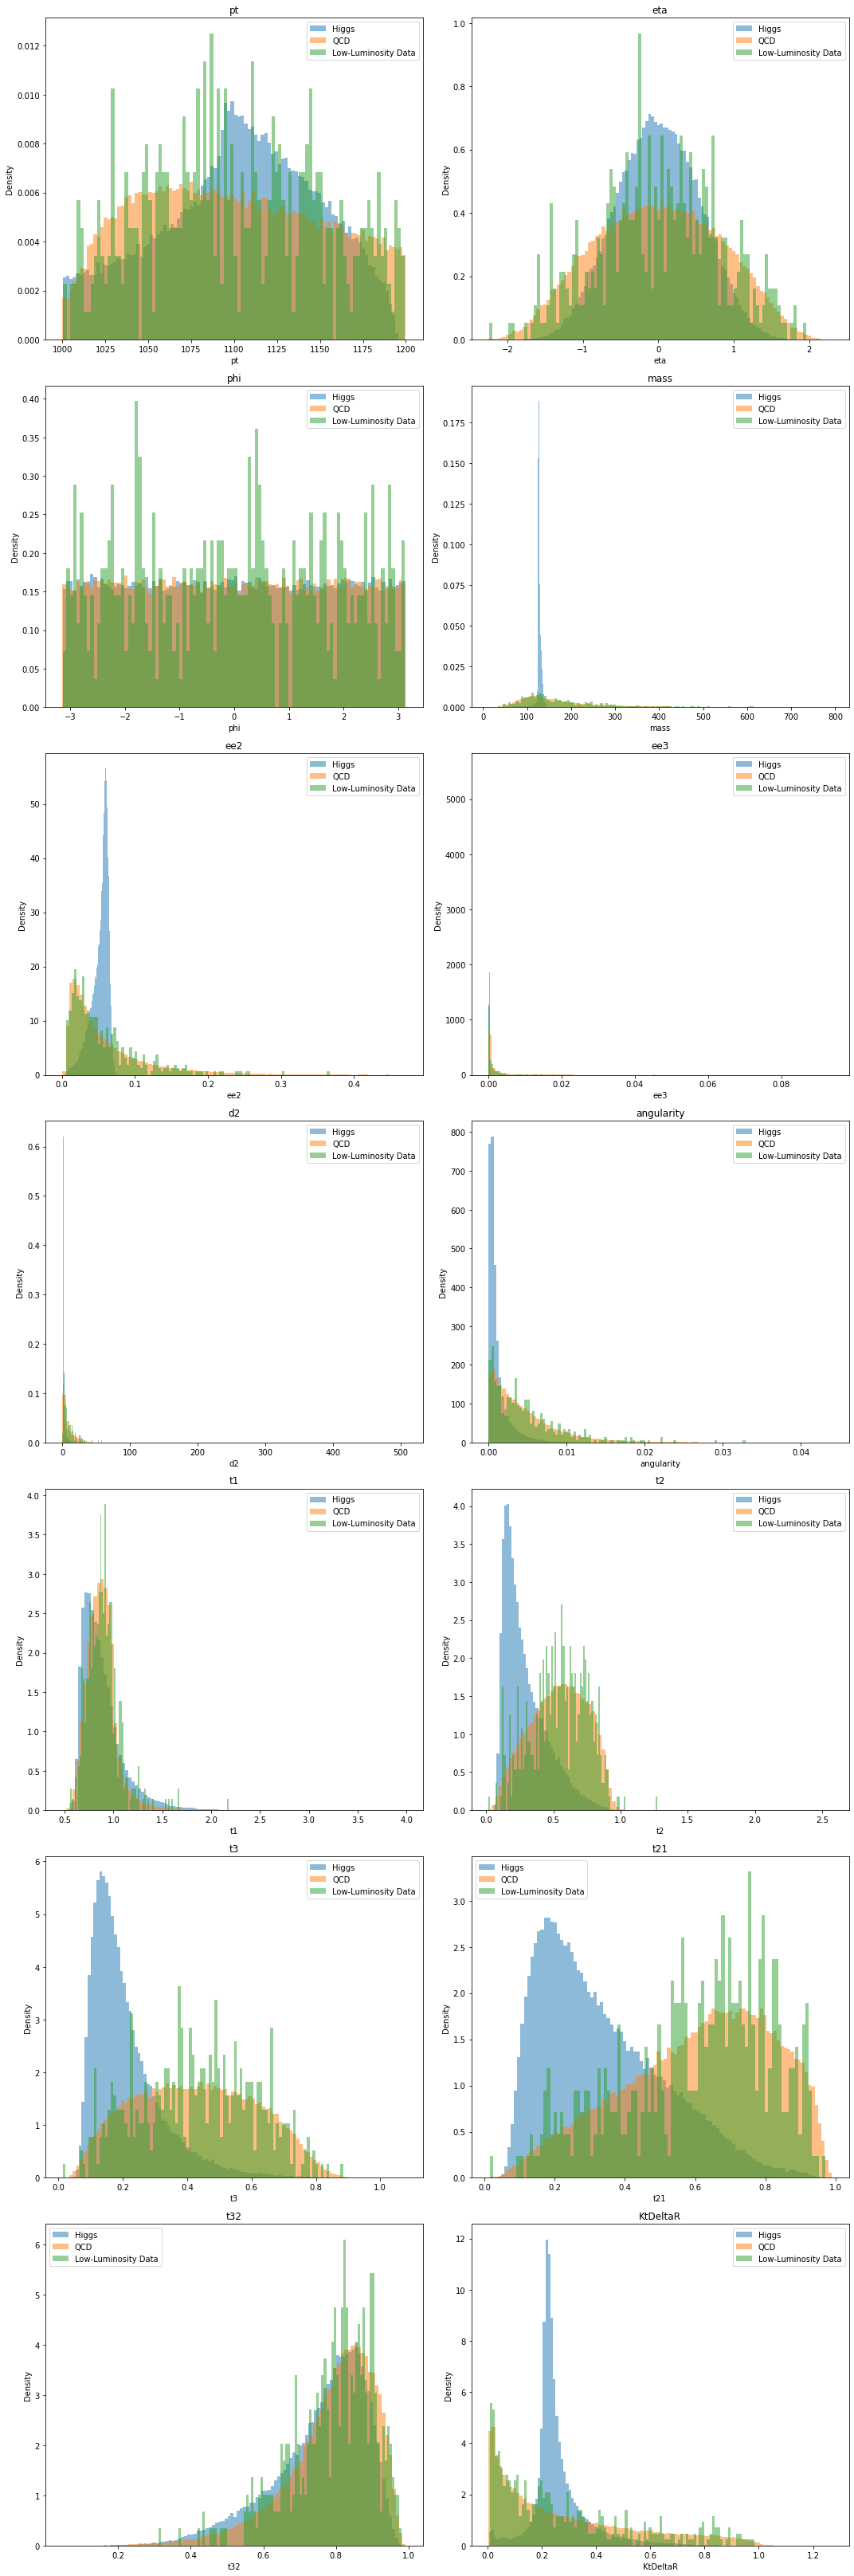

In [18]:
cols = higgs_df.columns.values
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_df[col],100,density=True,weights = np.full(higgs_df.shape[0],lowLum.shape[0]/higgs_df.shape[0]), alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_df[col],100,density=True,weights = np.full(qcd_df.shape[0],lowLum.shape[0]/qcd_df.shape[0]), alpha=.5, label='QCD')
    ax[i//2,i%2].hist(lowLum[col],100,density=True,alpha=.5, label='Low-Luminosity Data')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

### Optimizing the data
I am gonna use the same condition in Lab#7: mass \[125.6091423607632, 126.9275302079706].

In [19]:
range_collections = get_ranges(higgs_df,qcd_df, ['mass'])
higgs_opt, qcd_opt, lowLum_opt = cut_df_2(range_collections,higgs_df,qcd_df,lowLum)

In [21]:
# plt.hist(qcd_opt['pt'],200,density=True,weights=np.full(qcd_opt.shape[0],lowLum_opt.shape[0]/qcd_df.shape[0]))
# plt.hist(lowLum_opt['pt'],200,density=True,alpha=.5, label='Low-Luminosity Data')
# plt.show()
lowLum_opt.shape

(4, 14)

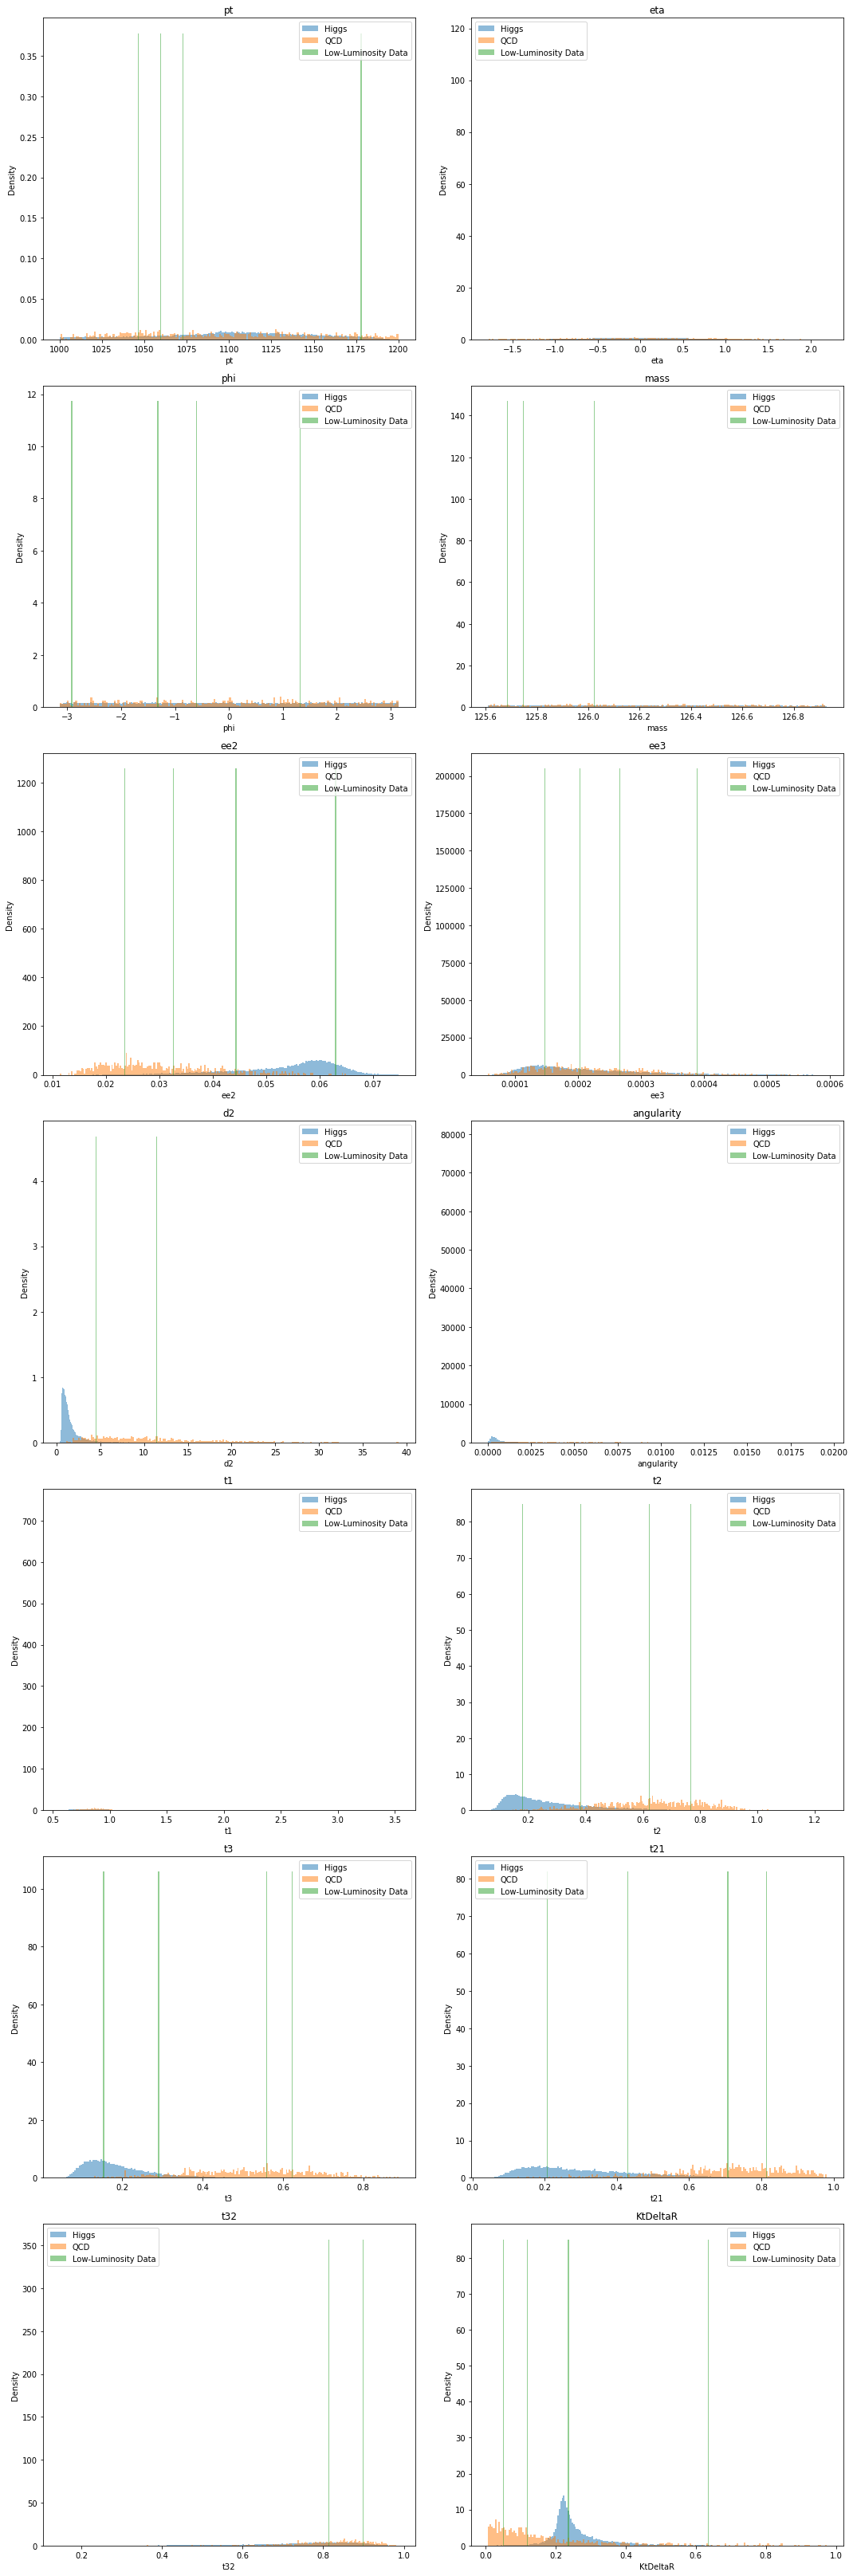

In [22]:
plt.rcParams["figure.figsize"] = (15,45)
fig,ax = plt.subplots(cols.shape[0]//2, 2)
for i, col in enumerate(cols):
    ax[i//2,i%2].hist(higgs_opt[col],200,density=True,weights = np.full(higgs_opt.shape[0],lowLum_opt.shape[0]/higgs_df.shape[0]),alpha=.5,label="Higgs")
    ax[i//2,i%2].hist(qcd_opt[col],200,density=True,weights = np.full(qcd_opt.shape[0],lowLum_opt.shape[0]/qcd_df.shape[0]),alpha=.5, label='QCD')
    ax[i//2,i%2].hist(lowLum_opt[col],200,density=True,alpha=.5, label='Low-Luminosity Data')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_xlabel(col)
    ax[i//2,i%2].set_ylabel('Density')
    ax[i//2,i%2].title.set_text(col)
plt.tight_layout()
plt.show()

In [23]:
sig_lowLum = sig_cal_2(higgs_opt,qcd_opt,lowLum,lowLum_opt)

print("The expected significance is %.2f." %sig_exp)
print("The observed significance of high-luminosity data is %.2f."%sig_lowLum)

The expected significance is 3.12.
The observed significance of high-luminosity data is 2.88.


## 95% Confidence Level of signal yields

In [32]:
ci_exp = stats.t.interval(alpha=0.95, df=higgs_opt.shape[0], loc=np.mean(higgs_opt.mass), scale=stats.sem(higgs_opt.mass)) 
print("The expected 95%% confidence level is: (%.4f, %.4f)"%(ci_exp[0],ci_exp[1]))

The expected 95% confidence level is: (126.2406, 126.2499)


In [34]:
ci_obs = stats.t.interval(alpha=0.95, df=lowLum_opt.shape[0], loc=np.mean(lowLum_opt.mass), scale=stats.sem(lowLum_opt.mass)) 
print("The observed 95%% confidence level is: (%.4f, %.4f)"%(ci_obs[0],ci_obs[1]))

The observed 95% confidence level is: (125.6128, 126.0232)


The upper limit of observed 95% confidence level is lower than the expected.